In [1]:
'''
This cell loads the model from the config file and initializes the viewer
'''
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path
import numpy as np
from nerfstudio.viewer.viewer import Viewer
from nerfstudio.configs.base_config import ViewerConfig
import cv2
from torchvision.transforms import ToTensor
from PIL import Image
from nerfstudio.utils import writer
import time
from threading import Lock
from nerfstudio.cameras.cameras import Cameras
from copy import deepcopy
from torchvision.transforms.functional import resize
from toad.zed import Zed
import warp as wp
from toad.optimization.rigid_group_optimizer import RigidGroupOptimizer
from toad.optimization.atap_loss import ATAPLoss
from toad.utils import *
wp.init()

# config = Path("outputs/nerfgun2/dig/2024-05-03_161203/config.yml")
# config = Path("outputs/nerfgun3/dig/2024-05-03_170424/config.yml")
# config = Path("outputs/nerfgun4/dig/2024-05-07_130351/config.yml")
# config = Path("outputs/painter_sculpture/dig/2024-05-10_132522/config.yml")
# config = Path("outputs/painter_sculpture/dig/2024-05-16_233028/config.yml")#with ruilongs v2
# config = Path("outputs/buddha_balls_poly/dig/2024-05-09_123412/config.yml")
# config = Path("outputs/buddha_balls_poly/dig/2024-05-16_231213/config.yml")#with ruilongs v2
# config = Path("outputs/cal_bear/dig/2024-05-15_155531/config.yml")#this one groups table with bear for some reason
# config = Path("outputs/bww_faucet/dig/2024-05-12_215440/config.yml")
# config = Path("outputs/cmk_tpose2/dig/2024-05-14_142439/config.yml")
# config = Path("outputs/cal_bear/dig/2024-05-17_142920/config.yml")#ruilong v2
# config = Path("outputs/mac_charger/dig/2024-05-17_145312/config.yml")
# config = Path("outputs/mac_charger2/dig/2024-05-17_152545/config.yml")
# config = Path("outputs/glue_gun/dig/2024-05-17_161408/config.yml")
# config = Path("outputs/buddha_balls_poly/dig/2024-05-19_122050/config.yml")# reuilong v2, 32-dim gauss
# config = Path("outputs/mac_charger/dig/2024-05-19_125443/config.yml")
# config = Path("outputs/mac_charger2/dig/2024-05-19_132100/config.yml")
# config = Path("outputs/mac_charger/dig/2024-05-20_191616/config.yml")#with antialias
# config = Path("outputs/buddha_balls_poly/dig/2024-05-20_192646/config.yml")
# config = Path("outputs/garfield_plushie/dig/2024-05-21_144709/config.yml")
config = Path("outputs/buddha_balls_poly/dig/2024-05-23_184345/config.yml")
# config=Path("outputs/buddha_balls/dig/2024-05-23_145359/config.yml")
# config=Path("outputs/buddha_balls_poly/dig/2024-05-23_153552/config.yml")
# config = Path("outputs/calbear/dig/2024-05-24_160735/config.yml")
OUTPUT_FOLDER = Path("renders/buddha_balls_poly")

assert OUTPUT_FOLDER.stem in str(config), "Output folder name does not match config name"
OUTPUT_FOLDER.mkdir(exist_ok=True,parents=True)
train_config,pipeline,_,_ = eval_setup(config)

dino_loader = pipeline.datamanager.dino_dataloader
train_config.logging.local_writer.enable = False
# We need to set up the writer to track number of rays, otherwise the viewer will not calculate the resolution correctly
writer.setup_local_writer(train_config.logging, max_iter=train_config.max_num_iterations)
v = Viewer(ViewerConfig(default_composite_depth=False,num_rays_per_chunk=-1),config.parent,pipeline.datamanager.get_datapath(),pipeline,train_lock=Lock())
try:
    pipeline.load_state()
except FileNotFoundError:
    print("No state found, starting from scratch")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Warp 1.1.0 initialized:
   CUDA Toolkit 11.5, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 4090" (24 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/chungmin/.cache/warp/1.1.0


[17:45:10] Auto image downscale factor of 1                                                 ]8;id=667645;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=707192;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

            Dataset is overriding orientation method to none                                ]8;id=123238;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=509514;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

            Dataset is overriding orientation method to none                                ]8;id=801614;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=737710;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

           Caching / undistorting train images                                            ]8;id=753387;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=670236;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#183\183]8;;\

Output()

Using cache found in /home/chungmin/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


Using layer norm
denoiser.1.weight loaded
denoiser.1.bias loaded
Dino data shape torch.Size([57, 66, 90, 64])
Loading instance feature model...


[17:45:13]  Dataset is overriding orientation method to none                                ]8;id=619616;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=493436;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

            Dataset is overriding orientation method to none                                ]8;id=368018;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=643420;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/buddha_balls_poly/garfield/2024-05-23_152531/nerfstudio_models/step-000008000.ckpt

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/buddha_balls_poly/dig/2024-05-23_184345/nerfstudio_models/step-000005999.ckpt

[17:45:14] disabled local writer                                                                           ]8;id=599596;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/utils/writer.py\writer.py]8;;\:]8;id=34224;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/utils/writer.py#185\185]8;;\

╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:7007   │
│   Websocket │ ws://0.0.0.0:7007     │
│             ╵                       │
╰─────────────────────────────────────╯

[17:45:15] Caching / undistorting eval images                                             ]8;id=437202;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=382640;file:///home/chungmin/Documents/please2/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#183\183]8;;\

Output()

In [2]:
"""
This cell defines a simple pose optimizer for learning a rigid transform offset given a gaussian model, star pose, and starting view
"""

def get_vid_frame(cap,timestamp):
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate the frame number based on the timestamp and fps
    frame_number = min(int(timestamp * fps),int(cap.get(cv2.CAP_PROP_FRAME_COUNT)-1))
    
    # Set the video position to the calculated frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    success, frame = cap.read()
    # convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

MATCH_RESOLUTION = 500
camera_input = 'zed_svo' # ['iphone','zed', 'iphone_vertical','zed_svo']
video_path = Path("motion_vids/buddha_balls_closeopen.MOV")
svo_path = Path("motion_vids/zed_box.svo2")
start_time = 0.3
import viser.transforms as vtf
cam_pose = None
if cam_pose is None:
    R = vtf.SO3.from_x_radians(np.pi/2).as_matrix()
    H = np.eye(4)
    H[:3,:3] = R
    cam_pose = torch.from_numpy(H).float()[None,:3,:]#TODO ground truth cam to yumi
if camera_input == 'iphone':
    init_cam = Cameras(camera_to_worlds=cam_pose,fx = 1137.0,fy = 1137.0,cx = 1280.0/2,cy = 720/2,width=1280,height=720)
    init_cam.rescale_output_resolution(MATCH_RESOLUTION/max(init_cam.width,init_cam.height))
elif camera_input == 'iphone_vertical':
    init_cam = Cameras(camera_to_worlds=cam_pose,fy = 1137.0,fx = 1137.0,cy = 1280/2,cx = 720/2,height=1280,width=720)
    init_cam.rescale_output_resolution(MATCH_RESOLUTION/max(init_cam.width,init_cam.height))
elif camera_input in ['zed','zed_svo']:
    try:
        zed.cam.close()
        del zed
    except:
        pass
    finally:
        zed = Zed(recording_file=str(svo_path.absolute()) if camera_input == 'zed_svo' else None, start_time=start_time)
    fps = 30    
    left_rgb,_,_ = zed.get_frame()
    K = zed.get_K()
    init_cam = Cameras(camera_to_worlds=cam_pose,fx = K[0,0],fy = K[1,1],cx = K[0,2],cy = K[1,2],width=left_rgb.shape[1],height=left_rgb.shape[0])
    init_cam.rescale_output_resolution(MATCH_RESOLUTION/max(init_cam.width,init_cam.height))
outputs = pipeline.model.get_outputs_for_camera(init_cam)
if pipeline.cluster_labels is not None:
    labels = pipeline.cluster_labels.int().cuda()
    group_masks = [(cid == labels).cuda() for cid in range(labels.max() + 1)]
else:
    labels = torch.zeros(pipeline.model.num_points).int().cuda()
    group_masks = [torch.ones(pipeline.model.num_points).bool().cuda()]
optimizer = RigidGroupOptimizer(pipeline.model,dino_loader,init_cam,group_masks, group_labels = labels, dataset_scale = pipeline.datamanager.train_dataset._dataparser_outputs.dataparser_scale, render_lock = v.train_lock)
rgb_renders = [] 

INIT RES 1920
[2024-05-29 00:45:15 UTC][ZED][INFO] Logging level INFO
Opened camera
[2024-05-29 00:45:15 UTC][ZED][INFO] [Init]  Depth mode: NONE
[2024-05-29 00:45:15 UTC][ZED][INFO] [Init]  Serial Number: S/N 23568386


/home/chungmin/anaconda3/envs/please2/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Group 1 has 108 neighbors
Group 2 has 385 neighbors
Group 3 has 467 neighbors
Group 4 has 222 neighbors
Group 5 has 241 neighbors
Group 6 has 1114 neighbors
Group 7 has 728 neighbors


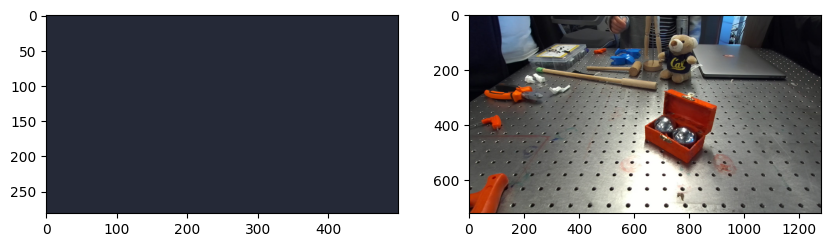

In [3]:
if camera_input in ['zed','zed_svo']:
    left_rgb, right_rgb,depth = zed.get_frame()
    target_frame_rgb = (left_rgb/255)
    right_frame_rgb = (right_rgb/255)
    optimizer.set_frame(target_frame_rgb,depth=depth)
else:
    assert video_path.exists()
    motion_clip = cv2.VideoCapture(str(video_path.absolute()))
    start=1
    end=2
    fps = 30
    frame = get_vid_frame(motion_clip,start)
    target_frame_rgb = ToTensor()(Image.fromarray(frame)).permute(1,2,0).cuda()
    optimizer.set_frame(target_frame_rgb)
_,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(outputs["rgb"].detach().cpu().numpy())
axs[1].imshow(target_frame_rgb.cpu().numpy())

Module toad.optimization.rigid_group_optimizer load on device 'cuda:0' took 1.49 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


Moviepy - Building video test_camopt.mp4.
Moviepy - Writing video test_camopt.mp4



Moviepy - Done !
Moviepy - video ready test_camopt.mp4


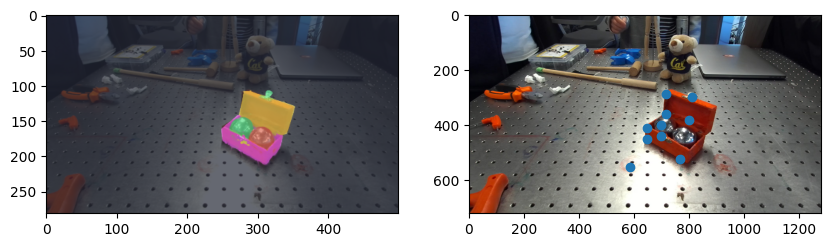

In [4]:
import moviepy.editor as mpy
xs,ys,outputs,renders = optimizer.initialize_obj_pose(render=True,niter=200,metric_depth=True)
_,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(outputs["rgb"].detach().cpu().numpy())
rescale = max(target_frame_rgb.shape[0],target_frame_rgb.shape[1])/MATCH_RESOLUTION
axs[1].scatter(xs.cpu().numpy()*rescale,ys.cpu().numpy()*rescale)
axs[1].imshow(target_frame_rgb.cpu().numpy())
axs[0].imshow(optimizer.rgb_frame.cpu().numpy(),alpha=.3)
if len(renders)>1:
    renders = [r.detach().cpu().numpy()*255 for r in renders]
    #save video as test_camopt.mp4
    out_clip = mpy.ImageSequenceClip(renders, fps=30)  
    out_clip.write_videofile("test_camopt.mp4")

In [5]:
from nerfstudio.utils.colormaps import apply_depth_colormap
import tqdm
import moviepy.editor as mpy
import plotly.express as px
import viser
def plotly_render(frame):
    fig = px.imshow(frame)
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),showlegend=False,yaxis_visible=False, yaxis_showticklabels=False,xaxis_visible=False, xaxis_showticklabels=False
    )
    return fig
fig = plotly_render(outputs['rgb'].detach().cpu().numpy())
try:
    frame_vis.remove()
except:
    pass
frame_vis = pipeline.viewer_control.viser_server.add_gui_plotly(fig, 9/16)
try:
    animate_button.remove()
    frame_slider.remove()
    reset_button.remove()
except:
    pass
def composite_vis_frame(target_frame_rgb,outputs):
    target_vis_frame = resize(target_frame_rgb.permute(2,0,1),(outputs["rgb"].shape[0],outputs["rgb"].shape[1])).permute(1,2,0)
    # composite the outputs['rgb'] on top of target_vis frame
    target_vis_frame = target_vis_frame*0.5 + outputs["rgb"]*0.5
    return target_vis_frame

try:
    render_button.remove()
    filename_input.remove()
    status_mkdown.remove()
except:
    pass
filename_input = v.viser_server.add_gui_text("File Name","render")
status_mkdown = v.viser_server.add_gui_markdown(" ")
render_button = v.viser_server.add_gui_button("Render Animation",color='green',icon=viser.Icon.MOVIE)
@render_button.on_click
def render(_):
    render_button.disabled = True
    render_frames = []
    camera = pipeline.viewer_control.get_camera(1080,1920,0)
    for i in tqdm.tqdm(range(len(optimizer.keyframes))):
        status_mkdown.content = f"Rendering...{i/len(optimizer.keyframes):.01f}"
        pipeline.model.eval()
        optimizer.apply_keyframe(i)
        with torch.no_grad():
            outputs = pipeline.model.get_outputs_for_camera(camera)
        render_frames.append(outputs["rgb"].detach().cpu().numpy()*255)
    status_mkdown.content = "Saving..."
    out_clip = mpy.ImageSequenceClip(render_frames, fps=fps)
    fname = filename_input.value
    (OUTPUT_FOLDER / 'posed_renders').mkdir(exist_ok=True)
    render_folder = OUTPUT_FOLDER / 'posed_renders'
    out_clip.write_videofile(f"{render_folder}/{fname}.mp4", fps=fps,codec='libx264')
    out_clip.write_videofile(f"{render_folder}/{fname}_mac.mp4", fps=fps,codec='mpeg4',bitrate='5000k')
    v.viser_server.send_file_download(f"{fname}_mac.mp4",open(f"{render_folder}/{fname}_mac.mp4",'rb').read())
    status_mkdown.content = "Done!"
    render_button.disabled = False

optimizer.register_keyframe()
if camera_input in ['zed','zed_svo']:
    while True:
        # If input camera is the zed, just loop it indefinitely until no more frames
        left_rgb, _, depth = zed.get_frame()
        if left_rgb is None:
            break
        target_frame_rgb = left_rgb/255
        optimizer.set_frame(target_frame_rgb,depth=depth)
        outputs = optimizer.step(50, metric_depth=True)
        v._trigger_rerender()
        optimizer.register_keyframe()
        target_vis_frame = composite_vis_frame(target_frame_rgb,outputs)
        vis_frame = torch.concatenate([outputs["rgb"],target_vis_frame],dim=1).detach().cpu().numpy()
        rgb_renders.append(vis_frame*255)
        fig = plotly_render(target_vis_frame.detach().cpu().numpy())
        frame_vis.figure = fig
elif camera_input in ['iphone','iphone_vertical','train_cam']:
    # Otherwise procces the video
    for t in tqdm.tqdm(np.linspace(start,end,int((end-start)*fps))):
        frame = get_vid_frame(motion_clip,t)
        target_frame_rgb = ToTensor()(Image.fromarray(frame)).permute(1,2,0).cuda()
        optimizer.set_frame(target_frame_rgb)
        outputs = optimizer.step(100, metric_depth=False)
        optimizer.register_keyframe()
        v._trigger_rerender()
        target_vis_frame = composite_vis_frame(target_frame_rgb,outputs)
        vis_frame = torch.concatenate([outputs["rgb"],target_vis_frame],dim=1).detach().cpu().numpy()
        fig = plotly_render(target_vis_frame.detach().cpu().numpy())
        frame_vis.figure = fig
        rgb_renders.append(vis_frame*255)
#save as an mp4
out_clip = mpy.ImageSequenceClip(rgb_renders, fps=fps)  

fname = str(OUTPUT_FOLDER / "optimizer_out.mp4")

out_clip.write_videofile(fname, fps=fps,codec='libx264')
out_clip.write_videofile(fname.replace('.mp4','_mac.mp4'),fps=fps,codec='mpeg4',bitrate='5000k')
optimizer.save_trajectory(OUTPUT_FOLDER / "keyframes.pt")
print("Saved keyframes to",OUTPUT_FOLDER / "keyframes.pt")

# Populate some viewer elements to visualize the animation
animate_button = v.viser_server.add_gui_button("Play Animation")
frame_slider = v.viser_server.add_gui_slider("Frame",0,len(optimizer.keyframes)-1,1,0)
reset_button = v.viser_server.add_gui_button("Reset Transforms")

@animate_button.on_click
def play_animation(_):
    for i in range(len(optimizer.keyframes)):
        optimizer.apply_keyframe(i)
        v._trigger_rerender()
        time.sleep(1/fps)
@frame_slider.on_update
def apply_keyframe(_):
    optimizer.apply_keyframe(frame_slider.value)
    v._trigger_rerender()
@reset_button.on_click
def reset_transforms(_):
    optimizer.reset_transforms()
    v._trigger_rerender()

Module toad.optimization.atap_loss load on device 'cuda:0' took 0.72 ms


End of recording file
[2024-05-29 00:46:26 UTC][ZED][WARNING] END OF SVO FILE REACHED in sl::ERROR_CODE sl::Camera::grab(sl::RuntimeParameters)
[2024-05-29 00:46:26 UTC][ZED][WARNING] END OF SVO FILE REACHED in sl::ERROR_CODE sl::Camera::grab(sl::RuntimeParameters)
Moviepy - Building video renders/buddha_balls_poly/optimizer_out.mp4.
Moviepy - Writing video renders/buddha_balls_poly/optimizer_out.mp4



Moviepy - Done !
Moviepy - video ready renders/buddha_balls_poly/optimizer_out.mp4
Moviepy - Building video renders/buddha_balls_poly/optimizer_out_mac.mp4.
Moviepy - Writing video renders/buddha_balls_poly/optimizer_out_mac.mp4



Moviepy - Done !
Moviepy - video ready renders/buddha_balls_poly/optimizer_out_mac.mp4
Saved keyframes to renders/buddha_balls_poly/keyframes.pt
